### Importing Libraries

In [1]:
from PIL import Image, PngImagePlugin
import numpy as np
import matplotlib.pyplot as plt
import shamirc as sis
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision
from torchvision import transforms as T

### Defining functions

In [2]:
def get_model(classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, classes)
    return model

In [3]:
def predict(model, image_path, device, score_threshold=0.5):
    transform = T.Compose([T.ToTensor(), ])
    image = transform(Image.open(image_path).convert("RGB"))
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])

    masks = prediction[0]['masks'].cpu().numpy()  # (N, 1, H, W)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    #print(scores, "\n", masks)

    if len(boxes) == 0:
        print("No predictions were made for this image.")
        return None

    plt.imshow(Image.open(image_path).convert("RGB"))
    save_box = []
    for i in range(len(boxes)):
        if scores[i] > score_threshold:
            mask = masks[i, 0]
            plt.contour(mask, colors='r', linewidths=2)  # Mask contour

            box = boxes[i]
            print(f"Box = {box}")
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='blue', fill=False, linewidth=2))  # Bounding box
            plt.text(box[0], box[1] - 10, f'{i+1}', color='yellow', fontsize=8, bbox=dict(facecolor='blue', alpha=0.5))  # Text label
            save_box.append(box)
    print(f"Number of Boxes Predicted = {len(save_box)}")
    plt.show()
    return save_box

### Share Generation (Encryption)

In [5]:
model = get_model(classes=2)
model.load_state_dict(torch.load("Number_Plate_Model.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

#### Enter Image and Encryption details and get the Detected Number Plate

Box = [172.46997 347.33398 222.54878 368.1833 ]
Number of Boxes Predicted = 1


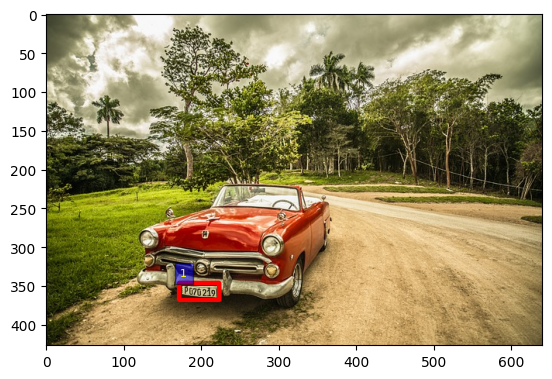

In [6]:
file_name=input("Enter name of the image file with extension and path:")
n = int(input("Enter no of shares(n): "))
k =int(input("Enter minimum shares to reveal secret(k): "))
img=Image.open(file_name)
boxes = predict(model, file_name, device=torch.device('cpu'))

Displaying the Detected Region (Secret)

In [7]:
xmin, ymin, xmax, ymax = map(int, boxes[0])
cropped_image = img.crop((xmin, ymin, xmax, ymax))
cropped_image

Size of Cropped Region

In [8]:
cropped_image.size

(50, 21)

#### Encrypting only cropped Region of Image

In [9]:
encrypted_img = sis.encrypt(n, k, cropped_image)

In [10]:
print(encrypted_img)

[[[[255  84 131]
   [ 82 177 131]
   [137  42  84]
   ...
   [194 216 184]
   [101 144  77]
   [119  94  58]]

  [[ 70  60 189]
   [190  57  39]
   [117 149 189]
   ...
   [170  12   2]
   [243 244 251]
   [128  17 206]]

  [[189 216 161]
   [169  16 248]
   [ 86  14 191]
   ...
   [198  48  48]
   [ 22 149  98]
   [169  10  76]]

  ...

  [[ 23 104 152]
   [ 81 194 220]
   [246 202 188]
   ...
   [232  14 199]
   [ 79  99  43]
   [  2 147  56]]

  [[ 73  45  17]
   [ 77   1 187]
   [121 189   9]
   ...
   [239 117  38]
   [ 48 254 107]
   [ 21  51 125]]

  [[195 148 214]
   [251 128 175]
   [ 72 229  39]
   ...
   [  5 160 127]
   [241 204 137]
   [ 62 144 172]]]


 [[[ 12  83 141]
   [ 77 130 139]
   [220 187  42]
   ...
   [112  95 230]
   [ 38 216  30]
   [ 52 123 247]]

  [[120 203 208]
   [198 244 170]
   [102 172 157]
   ...
   [ 27 193 172]
   [175 168  76]
   [ 69 251  42]]

  [[128  93  53]
   [221 168  63]
   [171  57  61]
   ...
   [195 185 206]
   [ 65  99 123]
   [ 12  76

In [11]:
np.shape(encrypted_img)

(3, 21, 50, 3)

#### Replace the Predicted Region with Encrypted Shares and save the files

In [12]:
def replace_with_encryption(img, encrypted_img, n : int, xmin, ymin, xmax, ymax, output_dir, metadata):
    img_temp = img.copy()
    bbox = [xmin, ymin, xmax, ymax]
    bbox_string = str(bbox)
    metadata.add_text("bounding_boxes", bbox_string)
    for i in range(n):
        region = Image.fromarray(encrypted_img[i].astype('uint8'))
        Image.Image.paste(img_temp, region, (xmin, ymin))
        img_temp.save(output_dir+str(i+1)+".png", pnginfo=metadata)

Calling the function and Saving Files

In [13]:
metadata = PngImagePlugin.PngInfo()
replace_with_encryption(img, encrypted_img, n, xmin, ymin, xmax, ymax, "Shares\share", metadata)
print("Shares Generation")

Displaying a secret region

In [14]:
img_temp1 = img.copy()
region = Image.fromarray(encrypted_img[0].astype('uint8'))
region

Displaying a Share

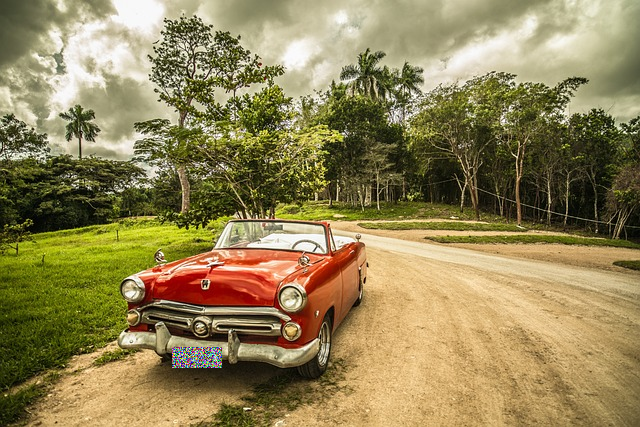

In [15]:
Image.Image.paste(img_temp1, region, (xmin, ymin))
img_temp1

### Recovery of Secret (Decryption)

Extracting Bounding Box from Image Metadata

In [23]:
def retrieve_bbox(image):
    metadata = image.info 
    # Retrieve bounding boxes from metadata
    if "bounding_boxes" in metadata:
        bounding_boxes = eval(metadata["bounding_boxes"])  # Convert string back to list
        return bounding_boxes
    else:
        return None

Information for Reconstructing Secret

In [24]:
n=int(input("Enter number of shares:"))
print("Enter the share numbers(1-n):")
shareno= [0 for _ in range (n)]
for i in range(n):
    shareno[i]=int(input())
share1 = Image.open(r"Shares\share"+str(shareno[0])+".png")
bbox = retrieve_bbox(share1) #can be done from any share
print (f"Share numbers: {shareno}")

Enter the share numbers(1-n):
Share numbers: [1, 3]


#### 1st Share (used for Extracting the non-secret region of the Image )

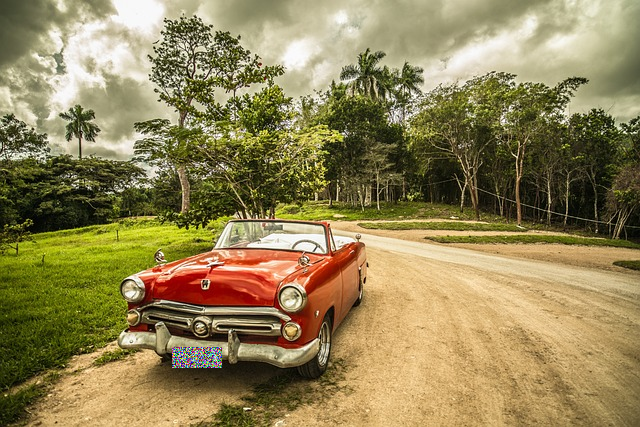

In [25]:
share1

#### Reconstructing Secret Region

In [26]:
secret_region = sis.decrypt(n, shareno, tuple(bbox))
print("Secret Generated!")
secret_img=Image.fromarray(secret_region.astype('uint8'))
secret_img

Secret Generated!


#### Pasting the secret region on the share

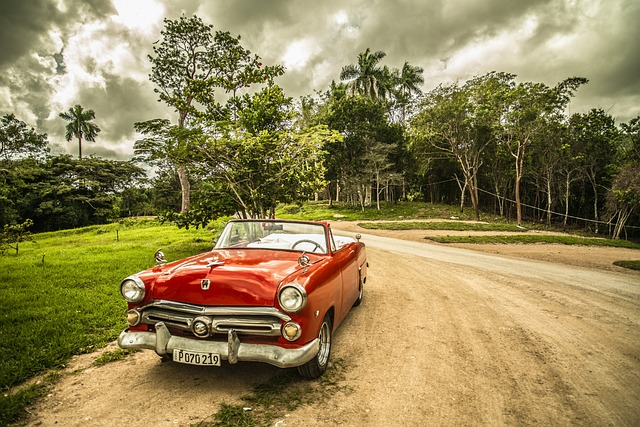

In [27]:
Image.Image.paste(share1, secret_img, (bbox[0], bbox[1]))
share1

In [28]:
share1.save('Secret.png')

### Checking Whether the Original Image and Reconstructed Image are equal

In [29]:
img1 = Image.open("test.jpg").convert('RGB') #original image
img2 = Image.open("Secret.png").convert('RGB') #secret image
arr1=img1.load()
arr2=img2.load()
w,h=img1.size
arr1 = np.array([[arr1[x, y] for y in range(h)] for x in range(w)])
arr2 = np.array([[arr2[x, y] for y in range(h)] for x in range(w)])
r = np.array_equal(arr1, arr2)
if (r==True): print("Images are Exactly same ")
else: print("Images are different")

Images are Exactly same 


#### So, it's proved that Original and Reconstructed Images are same